In [1]:
# Library import

import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_auc_score, auc, make_scorer, log_loss
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import GridSearchCV

random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [2]:
def bootstrap(y_true, y_score, iters):
    orig_auc = roc_auc_score(y_true, y_score)
    y_true0_ind = list(np.where(y_true == 0)[0])
    y_true1_ind = list(np.where(y_true == 1)[0])
    samp_size = len(y_score)
    estimated_auc = []
    for i in range(iters):
        if samp_size < 100:
            samp_indices = random.choices(y_true0_ind, k = len(y_true0_ind))
            samp_indices.extend(random.choices(y_true1_ind, k = len(y_true1_ind)))
        else:
            samp_indices = random.choices(range(0, samp_size), k = samp_size)
        samp_score = [y_score[i] for i in samp_indices]
        samp_true = [y_true[i] for i in samp_indices]
        estimated_auc.append(roc_auc_score(samp_true, samp_score) - orig_auc)
    lower = np.percentile(estimated_auc, 2.5)
    upper = np.percentile(estimated_auc, 97.5)
    return (orig_auc + lower, orig_auc + upper)

In [3]:
def bootstrap_pr(y_true, y_score, iters):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    orig_auc = auc(recall, precision)
    y_true0_ind = list(np.where(y_true == 0)[0])
    y_true1_ind = list(np.where(y_true == 1)[0])
    samp_size = len(y_score)
    estimated_auc = []
    for i in range(iters):
        if samp_size < 100:
            samp_indices = random.choices(y_true0_ind, k = len(y_true0_ind))
            samp_indices.extend(random.choices(y_true1_ind, k = len(y_true1_ind)))
        else:
            samp_indices = random.choices(range(0, samp_size), k = samp_size)
        samp_score = [y_score[i] for i in samp_indices]
        samp_true = [y_true[i] for i in samp_indices]
        precision, recall, thresholds = precision_recall_curve(samp_true, samp_score)
        auc_precision_recall = auc(recall, precision)
        estimated_auc.append(auc_precision_recall - orig_auc)
    lower = np.percentile(estimated_auc, 2.5)
    upper = np.percentile(estimated_auc, 97.5)
    return (orig_auc + lower, orig_auc + upper)

In [4]:
def model_results(actual_test_y, pred_y):
    #AUROC
    acc_test = roc_auc_score(actual_test_y, pred_y)
    [lower, upper] = bootstrap(actual_test_y, pred_y, 1000)
    print("Testing set 95%% AUROC: %5.3f [%5.3f, %5.3f]" % (acc_test, lower, upper))

    # AUPRC
    precision, recall, thresholds = precision_recall_curve(actual_test_y, pred_y)
    auc_precision_recall = auc(recall, precision)
    [lower, upper] = bootstrap_pr(actual_test_y, pred_y, 1000)
    print("Testing set 95%% AUPRC: %5.3f [%5.3f, %5.3f]" % (auc_precision_recall, lower, upper))

In [5]:
# Loading data
X_train = pd.read_csv("../Data/Split_Data/X_train.csv")
X_train_PCA = pd.read_csv("../Data/Split_Data/X_train_PCA.csv")
y_train = pd.read_csv("../Data/Split_Data/y_train.csv")
X_valid = pd.read_csv("../Data/Split_Data/X_valid.csv")
X_valid_PCA = pd.read_csv("../Data/Split_Data/X_valid_PCA.csv")
y_valid = pd.read_csv("../Data/Split_Data/y_valid.csv")
X_test = pd.read_csv("../Data/Split_Data/X_test.csv")
X_test_PCA = pd.read_csv("../Data/Split_Data/X_test_PCA.csv")
y_test = pd.read_csv("../Data/Split_Data/y_test.csv")

In [6]:
# Training dimensions
X_train_new = pd.concat([X_train, X_valid])
y_train_new = pd.concat([y_train, y_valid])
print(X_train_new.shape)
print(y_train_new.shape)
# Training PCA dimensions
X_train_PCA_new = pd.concat([X_train_PCA, X_valid_PCA])
print(X_train_PCA_new.shape)

(1136, 1124)
(1136, 1)
(1136, 75)


In [7]:
# Custom Tensor conversion function
class Cancer_Dataset(Dataset):
    def __init__(self, X, Y):
        self.x = X.copy()
        self.y = Y
        self.x_tensor = torch.tensor(self.x.values, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.y['Overall_Survival_Status'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x.iloc[idx].values.astype(np.float32), self.y.iloc[idx].values.astype(np.float32)

In [8]:
# Convert to Tensors
def tensor_convert(X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Convert to tensor
    train_ds = Cancer_Dataset(X_train, y_train)
    val_ds = Cancer_Dataset(X_valid, y_valid)
    test_ds = Cancer_Dataset(X_test, y_test)
    return train_ds, val_ds, test_ds

In [9]:
# Converet data to Tensor datasets
train_ds, val_ds, test_ds = tensor_convert(X_train, y_train, X_valid, y_valid, X_test, y_test)
train_ds_PCA, val_ds_PCA, test_ds_PCA = tensor_convert(X_train_PCA, y_train, X_valid_PCA, y_valid, X_test_PCA, y_test)

In [10]:
# Multi-layer perceptron model
class MLP(nn.Module):
    # MLP instantiation method
    def __init__(self, input_dim, output_dim, hidden_units=64, dropout_rate=0.5):
        # Inherit from torch.nn.Module
        super(MLP, self).__init__()
        
        # Assign MLP parameters to model attributes
        self.input_dim = input_dim
        self.hidden_dim = hidden_units
        # self.hidden_dim2 = int(5)
        self.output_dim = output_dim
        self.dr = dropout_rate
        
        # Define MTL layers
        self.fc0 = nn.Linear(in_features = input_dim, out_features = self.hidden_dim)
        self.batch_norm0 = nn.BatchNorm1d(self.hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p = self.dr)
        
        # self.fc1 = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim2)
        # self.batch_norm1 = nn.BatchNorm1d(self.hidden_dim2)
        # self.relu2 = nn.ReLU()
        self.fc_output = nn.Linear(in_features = self.hidden_dim, out_features = 1)
    
    # Forward pass method
    def forward(self, x):
        # Forward pass through model
        x = self.fc0(x)               # First fully-connected layer
        x = self.batch_norm0(x)        # Batch normalization
        x = self.relu1(x)           # Non-linear activation transformation
        x = self.dropout(x)
        # x = self.fc1(x)               # First fully-connected layer
        # x = self.batch_norm1(x)        # Batch normalization
        # x = self.relu2(x)           # Non-linear activation transformation
        # x = self.dropout(x)
        pred = self.fc_output(x)            # Final layer
        # Return model output
        return pred

In [11]:
# Model function wrapper
def run_model(train_ds, val_ds, test_ds, batch_size, opt, hu, dr, lr, wt_dc):
    # Set seeds
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False)
    val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
    test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

    # Define model input and output dimensions from data
    input_dim = len(train_ds[0][0])
    output_dim = 1

    # Instantiate model
    model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_units=hu, dropout_rate=dr)

    n_epochs = 200

    # Time model training
    print('\nTraining model...\n')

    early_stopping_count = 0
    stop_thresh = 0.001
    window = 21

    # Empty loss and accuracy vectors
    auc_train_scores = []
    auc_val_scores = []
    loss_train_scores = []
    loss_val_scores = []

    optimizer = opt(model.parameters(), lr = lr, weight_decay = wt_dc)
    loss_func = nn.BCEWithLogitsLoss()

    # Train model/iterate over epochs
    for epoch in range(n_epochs):
        # Initialize epoch metrics variables
        actual_train_y = []
        pred_train_y = []
        actual_val_y = []
        pred_val_y = []
        
        # Place model in training mode
        model.train()
        
        # Iterate through training data mini-batches
        for x, y in train_dl:
            
            # Forward pass
            y_pred = model(x)            # model predictions
            loss = loss_func(y_pred, y)  # loss function evaluation
            
            # Zero out the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()   # backpropagation
            optimizer.step()  # update parameters according to learning rate
            
            actual_train_y.extend(y.numpy())
            pred_train_y.extend(y_pred.detach().numpy())
        
        # Calculate epoch training loss and training auc
        train_loss = loss
        train_auc = roc_auc_score(actual_train_y, pred_train_y)
        
        loss_train_scores.append(train_loss.detach().numpy())
        auc_train_scores.append(train_auc)
        
        model.eval()
        
        # Iterate through validation data mini-batches
        for x, y in val_dl:
            
            # Forward pass
            val_y_pred = model(x)            # model predictions
            loss = loss_func(val_y_pred, y)  # loss function evaluation
            
            # Zero out the gradients
            optimizer.zero_grad()
            
            actual_val_y.extend(y.numpy())
            pred_val_y.extend(val_y_pred.detach().numpy())
        
        # Calculate epoch validation loss and validation auc
        val_loss = loss
        val_auc = roc_auc_score(actual_val_y, pred_val_y)
        
        auc_val_scores.append(val_auc)
        loss_val_scores.append(val_loss.detach().numpy())
        
        # Display training progress
        prog_disp_freq = 1   # frequency of training progress display
        if (((epoch + 1) % prog_disp_freq) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
            print("epoch: %s     train AUC: %5.4f     train loss: %5.4f     val AUC: %5.4f     val loss: %5.4f" % \
            (epoch, train_auc, train_loss, val_auc, val_loss))
        
        if epoch == window:
            best_loss = loss_val_scores[epoch]
        elif epoch > window:
            if loss_val_scores[epoch] >= (best_loss - stop_thresh):
                early_stopping_count += 1
            else:
                best_loss = loss_val_scores[epoch]
                early_stopping_count = 0
        
        if early_stopping_count == 10:
            break

    print('\nModel training complete.\n')

    """ Plot """
    fig = plt.figure()
    fig.set_facecolor('white')
    plt.plot(auc_train_scores, color='blue',label='Train')
    plt.plot(auc_val_scores, color='red', label='Validation')
    plt.title("AUROC over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    plt.show()

    """ Plot """
    fig = plt.figure()
    fig.set_facecolor('white')
    plt.plot(loss_train_scores, color='blue',label='Train')
    plt.plot(loss_val_scores, color='red', label='Validation')
    plt.title("Loss over epochs", fontsize=14)
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    plt.show()

    # Place model in evaluation model
    model.eval()

    # Initialize test set metrics variables
    actual_test_y = []
    pred_test_y = []

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate through test data mini-batches
        for x, y in test_dl:
            # Forward pass
            pred = model(x)  # model predictions
            
            actual_test_y.extend(y.numpy())
            pred_test_y.extend(pred.detach().numpy())

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    pred_y = sigmoid(np.array(pred_test_y))

    return [actual_test_y, pred_y]

In [12]:
def tune_model(train_ds):
    # Set seeds
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

    # Define model input and output dimensions from data
    input_dim = len(train_ds[0][0])
    output_dim = 1  # output dim. is equal to number of unique labels

    # Instantiate model
    model = NeuralNetBinaryClassifier(
        MLP,
        criterion=torch.nn.BCEWithLogitsLoss,
        verbose=False
    )

    param_grid = {
        'batch_size': [32, 64],
        'optimizer': [optim.SGD, optim.Adam],
        'optimizer__weight_decay': [1e-4, 1e-3],
        'optimizer__lr': [0.001, 0.0001],
        'module__dropout_rate': [0.5, 0.7],
        'module__hidden_units': [32, 128, 256],
        'module__input_dim': [input_dim],
        'module__output_dim': [output_dim],

    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, scoring = "f1")
    grid_result = grid.fit(train_ds.x_tensor, train_ds.y_tensor)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return grid_result.best_params_


In [13]:
# Full model best params
best_params = tune_model(train_ds)

Best: 0.756995 using {'batch_size': 32, 'module__dropout_rate': 0.7, 'module__hidden_units': 32, 'module__input_dim': 1124, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
0.629314 (0.046847) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 1124, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}
0.657040 (0.049072) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 1124, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
0.469676 (0.140585) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 1124, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0001, 'optimizer_


Training model...

epoch: 0     train AUC: 0.5851     train loss: 0.5921     val AUC: 0.6686     val loss: 0.6800
epoch: 1     train AUC: 0.7330     train loss: 0.5104     val AUC: 0.6923     val loss: 0.6431
epoch: 2     train AUC: 0.7588     train loss: 0.5784     val AUC: 0.7051     val loss: 0.6098
epoch: 3     train AUC: 0.8258     train loss: 0.4619     val AUC: 0.6997     val loss: 0.6061
epoch: 4     train AUC: 0.8588     train loss: 0.4480     val AUC: 0.7112     val loss: 0.5873
epoch: 5     train AUC: 0.8939     train loss: 0.4156     val AUC: 0.7165     val loss: 0.5939
epoch: 6     train AUC: 0.9090     train loss: 0.3676     val AUC: 0.7537     val loss: 0.5639
epoch: 7     train AUC: 0.9388     train loss: 0.3093     val AUC: 0.7479     val loss: 0.5393
epoch: 8     train AUC: 0.9311     train loss: 0.2720     val AUC: 0.7468     val loss: 0.5665
epoch: 9     train AUC: 0.9493     train loss: 0.2479     val AUC: 0.7535     val loss: 0.5513
epoch: 10     train AUC: 0.952

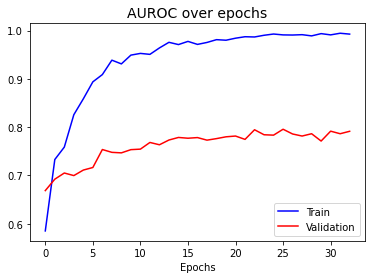

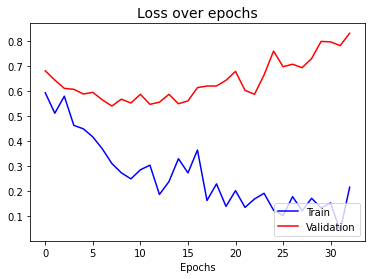

In [14]:
# Full model
actual_test_y, pred_y = run_model(train_ds, val_ds, test_ds, batch_size = best_params['batch_size'],\
        opt = best_params['optimizer'], hu = best_params['module__hidden_units'], \
        dr = best_params['module__dropout_rate'], lr = best_params['optimizer__lr'], \
        wt_dc = best_params['optimizer__weight_decay'])

In [15]:
# Full model results
model_results(actual_test_y, pred_y)

Testing set 95% AUROC: 0.769 [0.677, 0.853]
Testing set 95% AUPRC: 0.793 [0.682, 0.886]


In [16]:
# PCA model best params
best_params_PCA = tune_model(train_ds_PCA)

Best: 0.807122 using {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 256, 'module__input_dim': 75, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
0.600461 (0.099276) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 75, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}
0.567614 (0.166962) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 75, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
0.602515 (0.068752) with: {'batch_size': 32, 'module__dropout_rate': 0.5, 'module__hidden_units': 32, 'module__input_dim': 75, 'module__output_dim': 1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__lr': 0.0001, 'optimizer__weight


Training model...

epoch: 0     train AUC: 0.6550     train loss: 0.5370     val AUC: 0.7130     val loss: 0.6415
epoch: 1     train AUC: 0.7420     train loss: 0.5360     val AUC: 0.7412     val loss: 0.5767
epoch: 2     train AUC: 0.8193     train loss: 0.5203     val AUC: 0.7660     val loss: 0.5353
epoch: 3     train AUC: 0.8426     train loss: 0.4354     val AUC: 0.7883     val loss: 0.4981
epoch: 4     train AUC: 0.8594     train loss: 0.5822     val AUC: 0.8088     val loss: 0.4670
epoch: 5     train AUC: 0.8751     train loss: 0.4096     val AUC: 0.8271     val loss: 0.4428
epoch: 6     train AUC: 0.9094     train loss: 0.3544     val AUC: 0.8367     val loss: 0.4309
epoch: 7     train AUC: 0.8986     train loss: 0.4112     val AUC: 0.8402     val loss: 0.4192
epoch: 8     train AUC: 0.9159     train loss: 0.4155     val AUC: 0.8495     val loss: 0.4129
epoch: 9     train AUC: 0.9224     train loss: 0.3847     val AUC: 0.8521     val loss: 0.4031
epoch: 10     train AUC: 0.926

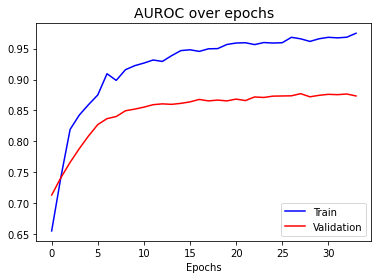

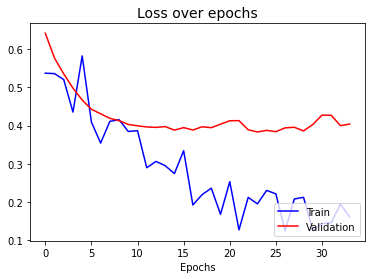

In [17]:
# PCA model
actual_test_y_PCA, pred_y_PCA = run_model(train_ds_PCA, val_ds_PCA, test_ds_PCA, batch_size = best_params_PCA['batch_size'],\
        opt = best_params_PCA['optimizer'], hu = best_params_PCA['module__hidden_units'], \
        dr = best_params_PCA['module__dropout_rate'], lr = best_params_PCA['optimizer__lr'], \
        wt_dc = best_params_PCA['optimizer__weight_decay'])

In [18]:
# PCA model results
model_results(actual_test_y_PCA, pred_y_PCA)

Testing set 95% AUROC: 0.880 [0.818, 0.931]
Testing set 95% AUPRC: 0.903 [0.840, 0.950]


In [19]:
# Export Data
pd.DataFrame(pred_y_PCA).to_csv("../Predictions/MLP_PCA_Pred.csv", index = False, header=None)
pd.DataFrame(pred_y).to_csv("../Predictions/MLP_Pred.csv", index = False, header=None)